# MRI Brain Tumor Classification

### Introduction

This is a personal project to practice image classification using tensorflow. The project should be run in WSL to utilize GPU acceleration to speed up training. 

The following __[dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset/data)__ is used for this project. The training and testing data is already separated by the creator of the dataset, so I will be using that split.


### Package Imports

In [38]:
import tensorflow as tf

import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

#### Packages Used
* Tensorflow for neural network
* Pathlib for accessing dataset location
* Numpy for algebra operations
* Pandas for dataframes
* Matplotlib for data visualization

### Image Preprocessing

In [39]:
DATA_DIR = pathlib.Path('Dataset')
TRAIN_DIR = DATA_DIR / 'Training'
TEST_DIR = DATA_DIR / 'Testing'

BATCH_SIZE = 16
IMG_HEIGHT = 512
IMG_WIDTH = 512

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    color_mode='grayscale',
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE)

NUM_CLASSES = len(train_ds.class_names)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


#### Input Data

Here is a bar graph of the number of training and testing data split by the the 4 possible classifications. And a table with the count of elements of each classification.

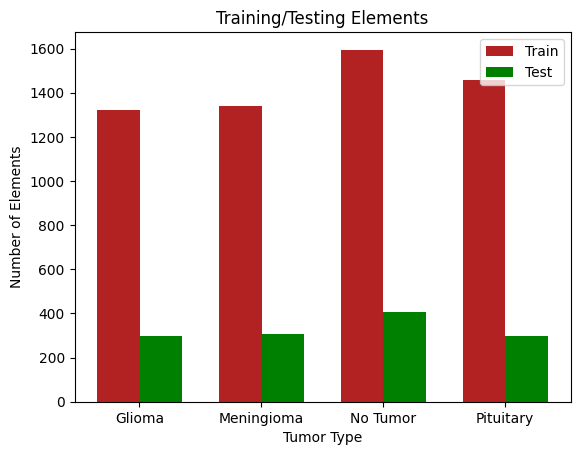

In [104]:
CLASS_NAMES = ['Glioma', 'Meningioma', 'No Tumor', 'Pituitary']
LEGEND_LABELS = ['Train', 'Test']

value_dict = {'Glioma':[0,0], 'Meningioma':[0,0], 'No Tumor':[0,0], 'Pituitary':[0,0]}
l1, l2 = list(), list()
label_list = []

for images, labels in train_ds:
    for i in labels:
        value_dict[CLASS_NAMES[i]][0] += 1    

for images, labels in val_ds:
    label_list.extend(labels.numpy().tolist())
    for i in labels:
        value_dict[CLASS_NAMES[i]][1] += 1


for value in value_dict.values():
    l1.append(value[0])
    l2.append(value[1])

bar1 = np.arange(NUM_CLASSES) 
bar2 = [x + 0.35 for x in bar1] 
plt.bar(bar1, l1, width=0.35, label='Train', color='firebrick')
plt.bar(bar2, l2, width=0.35, label='Test', color='green')
plt.xticks(np.arange(0.1725, 4.1725, 1), list(CLASS_NAMES))

plt.xlabel('Tumor Type')
plt.ylabel('Number of Elements')
plt.legend(LEGEND_LABELS, loc='upper right')
plt.title('Training/Testing Elements')

plt.show()

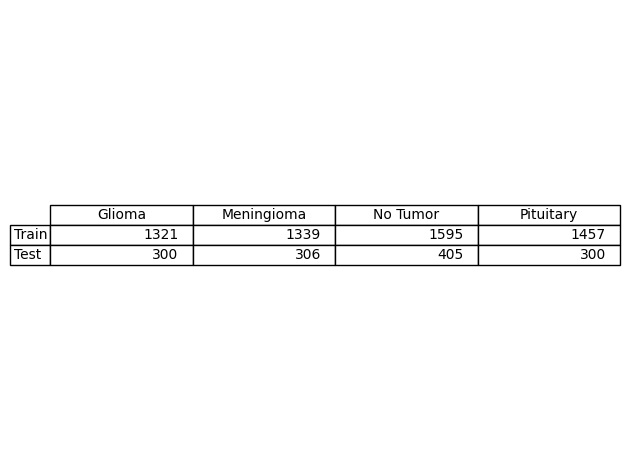

In [105]:
# labels = pd.Series(label_list)
# val_count = labels.value_counts()

fig, ax = plt.subplots()

# hide axes
fig.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')

df = pd.DataFrame.from_dict(value_dict)

ax.table(cellText=df.values, colLabels=df.columns, loc='center', rowLabels=LEGEND_LABELS)

fig.tight_layout()
plt.show()


Here are some example images from the verification dataset. They are grayscale, but are represented here with colors for higher contrast. The title above every image is its classification as provided by the dataset.

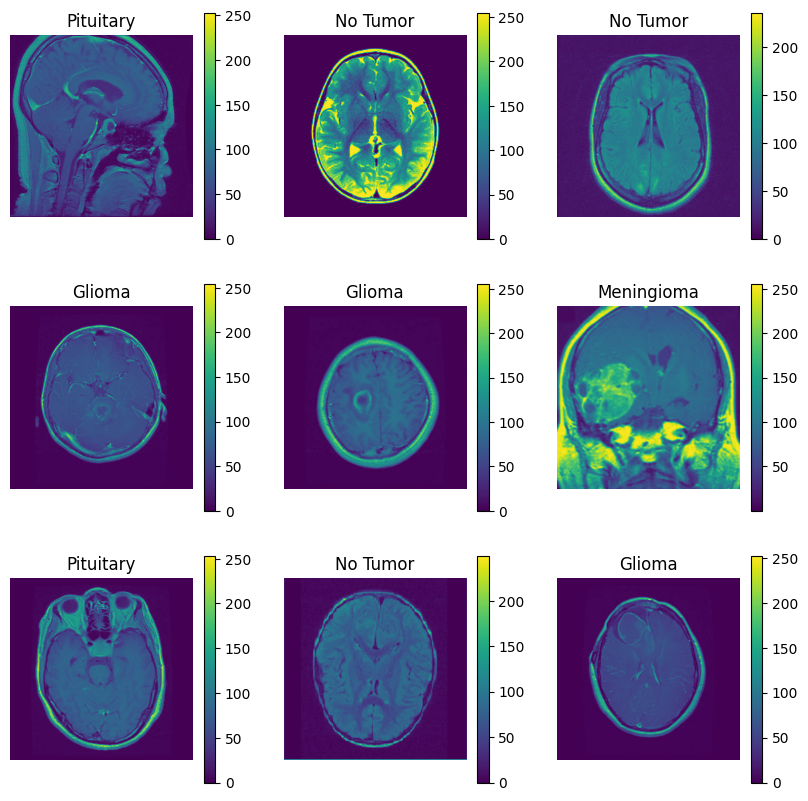

In [43]:
plt.figure(figsize=(10, 10))
for images, labels in val_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(CLASS_NAMES[labels[i]])
        plt.axis("off")
        plt.colorbar()

plt.show()

### Model Training

In [44]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

model = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
    tf.keras.layers.Rescaling(1./255),

    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 5, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(128, activation='relu'),
    
    tf.keras.layers.Dense(NUM_CLASSES)
])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'])

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=1
)

357/357 [==============================] - 499s 1s/step - loss: 0.6328 - accuracy: 0.7668 - val_loss: 0.5427 - val_accuracy: 0.8093


This was run directly through windows and did not have the GPU speedup that WSL would provide. With the speedup a single epoch lasts around 11s on my machine, so around a 6x speed-up. 

The model ends with a 96.5% accuracy with around a 1% margin of error after 15 epochs.

### Results

##### Model Testing

In [45]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions_native = probability_model.predict(val_ds) # Predictions on natively run model

82/82 [==============================] - 26s 309ms/step


Here is a display of some images from the validation set followed by a bar graph of the predictions made by the model. The classifications have been shortened to the first letter due to the large graphic. The classification is written out above the image, it will be red if the model is incorrect. Likewise, only the correct bar in the bar graph will be blue, the incorrect predictions will be red.

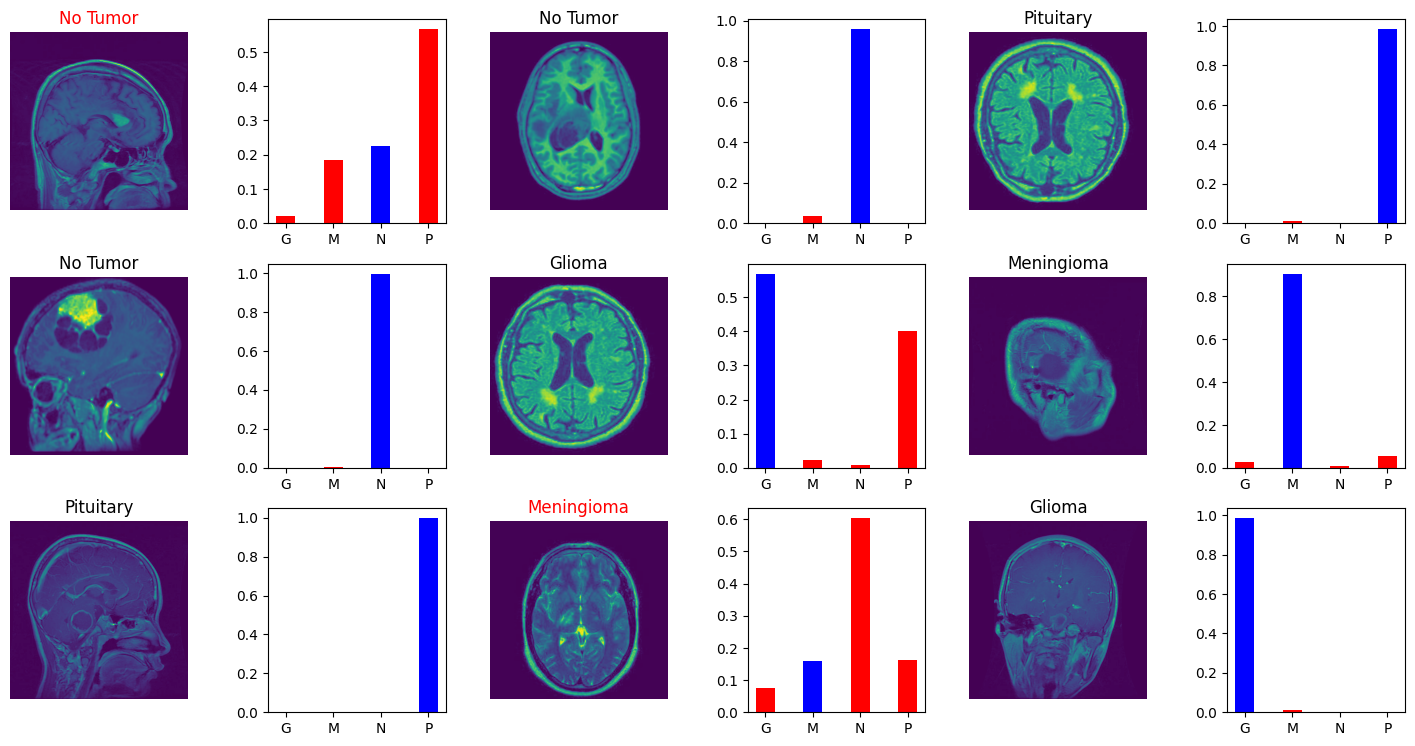

<Figure size 640x480 with 0 Axes>

In [153]:
CLASS_NAMES_SHORT = ['G', 'M', 'N', 'P']
bar_colors = ['red', 'red', 'red', 'red']

fig = plt.figure(figsize=(18, 9))

outer = gridspec.GridSpec(3, 3, wspace=0.1, hspace=0.2)

for i in range(9):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i], wspace=0.45, hspace=0.2)

    image = plt.Subplot(fig, inner[0])
    graph = plt.Subplot(fig, inner[1])

    # Image settings
    image.imshow(images[i].numpy())
    image.axis('off')
    image.title.set_text(CLASS_NAMES[label_list[i]])
    if(np.argmax(predictions_native[i]) != label_list[i]):
        image.title.set_color('red')

    # Graph settings
    bar_colors[label_list[i]] = 'blue'
    graph.bar(CLASS_NAMES_SHORT, predictions_native[i], width=0.4, color = bar_colors)
    
    # Plotting Data    
    fig.add_subplot(image)
    fig.add_subplot(graph)

    # Resetting colors
    for i in range(len(bar_colors)):
        bar_colors[i] = 'red'
plt.show()
plt.set_cmap("viridis") 

##### Model Statistics

Here are two line graphs demonstrating model accuracy and model loss over the epochs. The higher training accuracy and lower loss value compared to testing data indicate slight overfitting

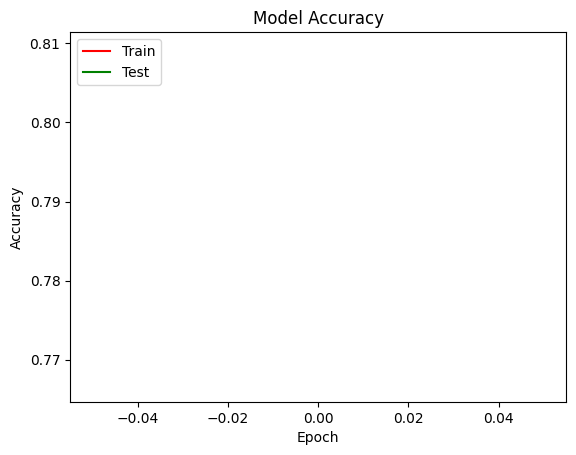

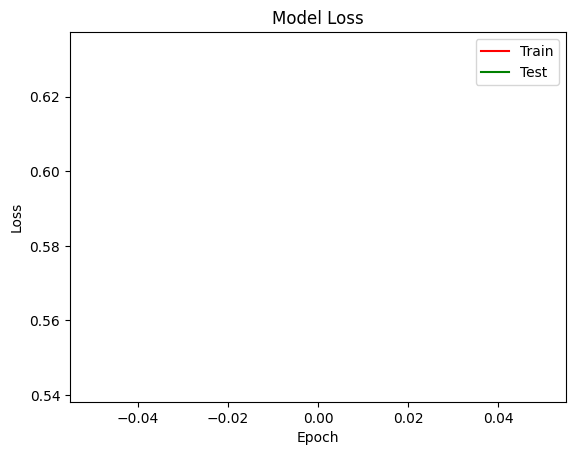

In [48]:
plt.plot(history.history['accuracy'], color='red')
plt.plot(history.history['val_accuracy'], color='green')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(LEGEND_LABELS, loc='upper left')
plt.show()

plt.plot(history.history['loss'], color='red')
plt.plot(history.history['val_loss'], color='green')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(LEGEND_LABELS, loc='upper right')
plt.show()

##### Prediction Accuracy

Here is a correlation matrix of the incorrect predictions that the model has made. The model struggles with Meningiomas the most. 

The improper classifications mostly come from:
1. Glicomas being classified as Meningiomas
1. Meningiomas being misclassified as one of the other three classes

These results are still good since there is ~92% accuracy when classifying Meningiomas compared to ~97% overall accuracy


If this model is used for identifying tumors and not classifying them, then:

This model does not have false positives in the tests run.

The model also has a (3/906)~0.33% chance to throw a false negative.

In [149]:
# Generate incorrect prediction matrix
def gen_inc_pred_matrix(predictions:list, labels=label_list) -> np.ndarray:
    matrix = [[0 for x in range(NUM_CLASSES)] 
                for y in range(NUM_CLASSES)] 
    
    for i in range(len(labels)):
        corr = labels[i]
        pred = np.argmax(predictions[i])
        if corr != pred:
            matrix[corr][pred] += 1
    return np.array(matrix)

# Generate Prediction Graph
def gen_pred_graph(matrix: np.ndarray) -> None:
    fig, ax = plt.subplots()
    fig.tight_layout()
    im = ax.imshow(matrix, cmap='Reds')
    ax.set_xticks(range(NUM_CLASSES), labels=CLASS_NAMES)
    ax.set_yticks(range(NUM_CLASSES), labels=CLASS_NAMES)
    plt.ylabel('Label', weight='bold')
    plt.xlabel('Predicted', weight='bold')
    plt.title('Incorrect Predictions', weight='bold')

    for i in range(NUM_CLASSES):
        for j in range(NUM_CLASSES):
            text = ax.text(j, i, matrix[i, j], 
                            ha='center', va='center',)

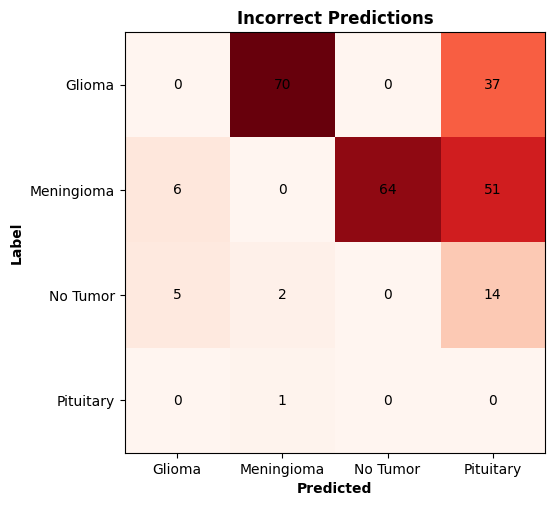

In [150]:
inc_pred_matrix = gen_inc_pred_matrix(predictions_native)
gen_pred_graph(inc_pred_matrix)

#### Attempt to Improve

I made an attempt to improve the accuracy of the model by ensembling together multiple models and taking the most common prediction that they give, but that resulted in a very small gain in the accuracy(less than 0.25%) when using 5 separately trained models compared to only using the most accurate of the 5. It was able to correctly predict 2 more images correctly(1275 vs 1277) compared to the best model of the set, while increasing computation time by a factor of 5.

82/82 [==============================] - 89s 1s/step


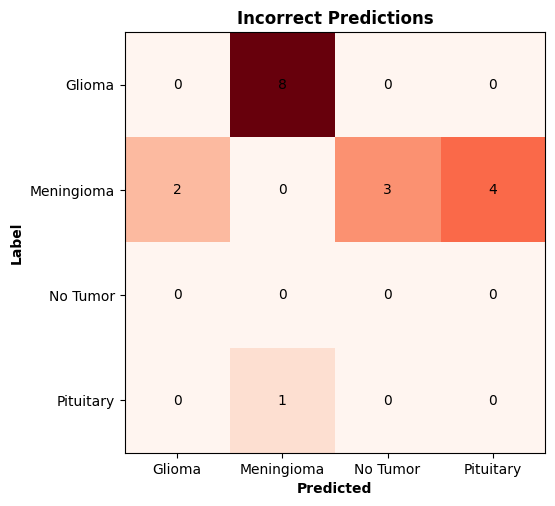

In [154]:
NUM_MODELS = 5
model_list = []

for i in range(1,NUM_MODELS+1):
    model_list.append(tf.keras.saving.load_model(f'Models/m{i}.h5'))

multi_predictions = np.zeros_like(model_list[0])

for model in model_list:
    prob_mod = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
    pred = prob_mod.predict(val_ds)
    multi_predictions = np.add(multi_predictions, pred)

multi_predictions = multi_predictions/(NUM_MODELS-1)

multi_inc_pred_matrix = gen_inc_pred_matrix(multi_predictions)
gen_pred_graph(multi_inc_pred_matrix)

#### Good Saved Model

One of the best trained models that I have been able to train has an accuracy of 97.25% on the test set is m5.h5 under the Models directory, here is a correlation matrix of the incorrect predictions of this model

82/82 [==============================] - 25s 303ms/step


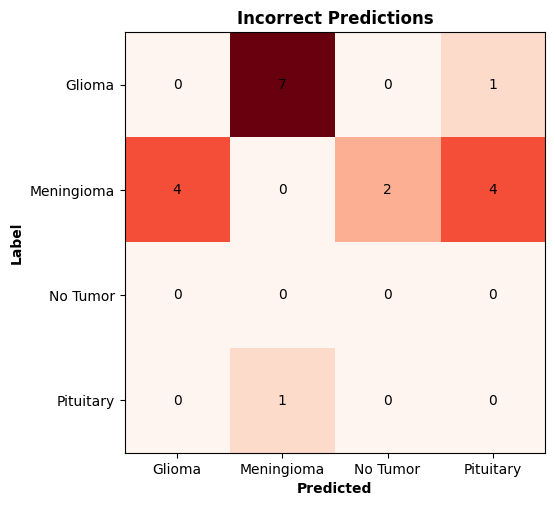

In [152]:
gmodel = tf.keras.Sequential([tf.keras.saving.load_model('Models/m3.h5'), tf.keras.layers.Softmax()])
predictions_gm = gmodel.predict(val_ds)

gen_pred_graph(gen_inc_pred_matrix(predictions_gm, label_list))

### Conclusions

Overall this is a good model, it can be improved in some ways to increase validation accuracy. These improvements would include techniques to prevent overfitting, be that modifying the data inputs or changing the model itself. 

This project was used as a demonstration, and should not be used for any medical decisions. I may return to this project in the future and try to improve the accuracy when I am more skilled at machine learning, but I am currently satisfied with the results that I have received and skills I have gained from this project.